In [1]:
import pandas as pd

In [2]:
df_1 = pd.read_csv('./training_data_08-29-2022-21-20-03.csv')
df_2 = pd.read_csv('./training_data_08-29-2022-21-23-40.csv')
df_3 = pd.read_csv('./training_data_08-31-2022-14-43-01.csv')
df = pd.concat([df_1, df_2, df_3])

# Analyse Data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7962 entries, 0 to 3678
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  7962 non-null   int64  
 1   i_sensor_1  7962 non-null   int64  
 2   i_sensor_2  7962 non-null   int64  
 3   i_sensor_3  7962 non-null   int64  
 4   o_left      7962 non-null   bool   
 5   o_right     7962 non-null   bool   
 6   i_sensor_4  7962 non-null   float64
 7   i_sensor_5  7962 non-null   float64
dtypes: bool(2), float64(2), int64(4)
memory usage: 451.0 KB


<AxesSubplot:>

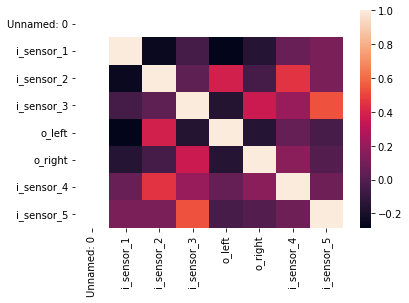

In [4]:
import seaborn as sns
sns.heatmap(df.corr())

# Scale/convert input values

In [5]:
df = df.astype({'o_left': int, 'o_right': int})   

In [6]:
df.head()

,Unnamed: 0,i_sensor_1,i_sensor_2,i_sensor_3,o_left,o_right,i_sensor_4,i_sensor_5
0,0,600,61,87,0,0,88.0,75.0
1,0,600,65,87,0,0,100.0,76.0
2,0,600,65,87,0,0,100.0,76.0
3,0,600,65,87,0,0,57.0,76.0
4,0,600,65,88,0,0,57.0,76.0


In [7]:
df[df['o_left']==1]

,Unnamed: 0,i_sensor_1,i_sensor_2,i_sensor_3,o_left,o_right,i_sensor_4,i_sensor_5
16,0,600,76,69,1,0,63.0,66.0
20,0,600,73,69,1,0,65.0,62.0
118,0,120,200,72,1,0,73.0,63.0
119,0,121,200,79,1,0,73.0,64.0
120,0,120,200,87,1,0,72.0,66.0
...,...,...,...,...,...,...,...,...
3628,0,111,88,35,1,0,58.0,30.0
3629,0,190,81,38,1,0,58.0,28.0
3630,0,259,76,33,1,0,57.0,26.0
3631,0,600,71,42,1,0,57.0,28.0


# Set Train and test 

In [8]:
from sklearn.model_selection import train_test_split
X = df.drop(['o_left','o_right','Unnamed: 0'],axis=1).values
y = df[['o_left','o_right']].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30,random_state=101)

# Create neural network

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout

In [10]:
import os
model = Sequential()

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="accuracy",
    min_delta=2,
    patience=30,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

X_train.shape

(5573, 5)

In [11]:
model.add(Dense(units=8, input_dim=5,activation='relu'))

model.add(Dense(units=10,activation='relu'))

model.add(Dense(units=4,activation='relu'))

model.add(Dense(2,activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model

In [12]:
model.fit(x=X_train, 
          y=y_train, 
          epochs=800,
          validation_data=(X_test, y_test), verbose=1,
          callbacks=[early_stopping]
         )

Epoch 1/800
175/175 [==============================] - 1s 2ms/step - loss: 0.6904 - accuracy: 0.8879 - val_loss: 0.4654 - val_accuracy: 0.9146
Epoch 2/800
175/175 [==============================] - 0s 1ms/step - loss: 0.4327 - accuracy: 0.9094 - val_loss: 0.4007 - val_accuracy: 0.9142
Epoch 3/800
175/175 [==============================] - 0s 998us/step - loss: 0.3829 - accuracy: 0.9010 - val_loss: 0.3632 - val_accuracy: 0.9067
Epoch 4/800
175/175 [==============================] - 0s 1ms/step - loss: 0.3575 - accuracy: 0.8983 - val_loss: 0.3418 - val_accuracy: 0.9021
Epoch 5/800
175/175 [==============================] - 0s 986us/step - loss: 0.3445 - accuracy: 0.8934 - val_loss: 0.3293 - val_accuracy: 0.9033
Epoch 6/800
175/175 [==============================] - 0s 980us/step - loss: 0.3341 - accuracy: 0.8904 - val_loss: 0.3360 - val_accuracy: 0.8882
Epoch 7/800
175/175 [==============================] - 0s 1ms/step - loss: 0.3291 - accuracy: 0.8825 - val_loss: 0.3203 - val_accuracy: 

In [13]:
model_loss = pd.DataFrame(model.history.history)

<AxesSubplot:>

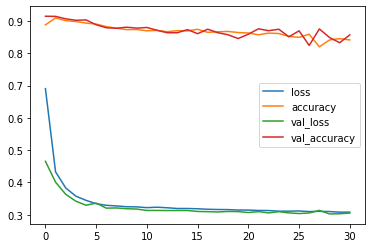

In [14]:
model_loss.plot()

In [15]:
model.save('car_game_model.h5')

In [16]:
import keras
model = keras.models.load_model('car_game_model.h5')

In [20]:
from car_game.car_game import CarGame
from car_game.road_enum import RoadEnum
    
car_game = CarGame(screen_size=(1280, 720), car_speed=6, frame_rate=60,
                   road=RoadEnum.THREE, sensor_threshold=200, generate_train_data=False, nn_model=model, 
                   probability_to_decide=0.60)

car_game.start_game()


1/1 [==============================] - 0s 14ms/step
{'i_sensor_1': 600, 'i_sensor_2': 94, 'i_sensor_3': 61, 'i_sensor_4': 200, 'i_sensor_5': 51}
1/1 [==============================] - 0s 14ms/step
{'i_sensor_1': 600, 'i_sensor_2': 60, 'i_sensor_3': 61, 'i_sensor_4': 200, 'i_sensor_5': 51}
1/1 [==============================] - 0s 12ms/step
{'i_sensor_1': 600, 'i_sensor_2': 68, 'i_sensor_3': 62, 'i_sensor_4': 200, 'i_sensor_5': 52}
1/1 [==============================] - 0s 14ms/step
{'i_sensor_1': 297, 'i_sensor_2': 54, 'i_sensor_3': 63, 'i_sensor_4': 200, 'i_sensor_5': 52}
1/1 [==============================] - 0s 12ms/step
{'i_sensor_1': 161, 'i_sensor_2': 54, 'i_sensor_3': 70, 'i_sensor_4': 200, 'i_sensor_5': 54}
1/1 [==============================] - 0s 14ms/step
{'i_sensor_1': 96, 'i_sensor_2': 29, 'i_sensor_3': 76, 'i_sensor_4': 200, 'i_sensor_5': 57}
1/1 [==============================] - 0s 12ms/step
{'i_sensor_1': 68, 'i_sensor_2': 31, 'i_sensor_3': 82, 'i_sensor_4': 200, 'i_se